# Simulation test code

## Simple 1-node network model with Wilson-Cowan type dynamics 

#### Takuya Ito (taku.ito1@gmail.com)
#### 11/29/2018

In [2]:
import numpy as np
import BalloonWindkessel as bw
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('white')

# 1.0 Define functions

Firing rate equation for a single node

$$\tau_1 \frac{dx_1}{dt} = -x_1 + f\Big( w_{11} x_1 + b_1 + s_1 \Big) \qquad \qquad (1)$$


Where $f(x)$ refers to the nonlinear transfer function, $\tau_i$ refers to the time constant of neuron $i$, and $s_i$ is the gain on neuron $i$.


In [22]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def runSim1D(w11,d,b,s,t,xinit1,tau,dt=.1,function='sigmoid'):
    I1 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+b+d[i-1]+s[i-1]) 
        i1k1 = i1k1/tau
        
        i1a = I1[i-1] + i1k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+b+d[i]+s[i])
        i1k2 = i1k2/tau
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        
    return I1[25:]

def findFP(w11,b,s,t,xinit1,tau,dt=.1):
    """
    Finds the fixed point of the model for a particular parameter regime
    """
    I1 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+b+s) 
        i1k1 = i1k1/tau
        
        i1a = I1[i-1] + i1k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+b+s)
        i1k2 = i1k2/tau
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        
        if I1[i] == I1[i-1] == I1[i-2]: 
            I1fp = I1[i] 
            break        
        
    return I1fp

# 2.0 Run simulations

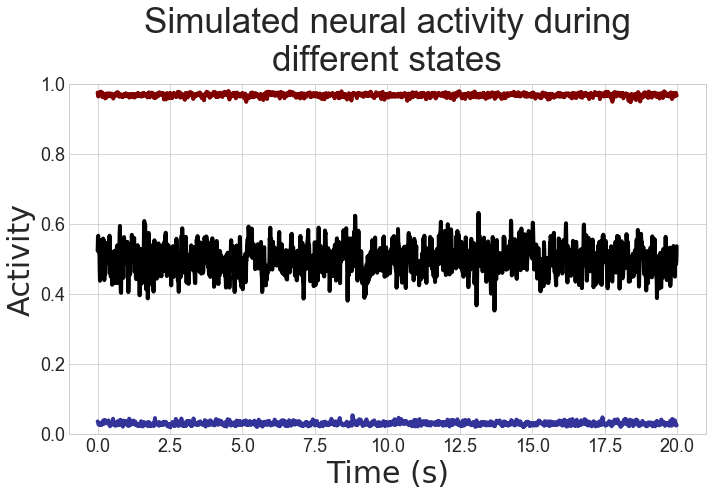

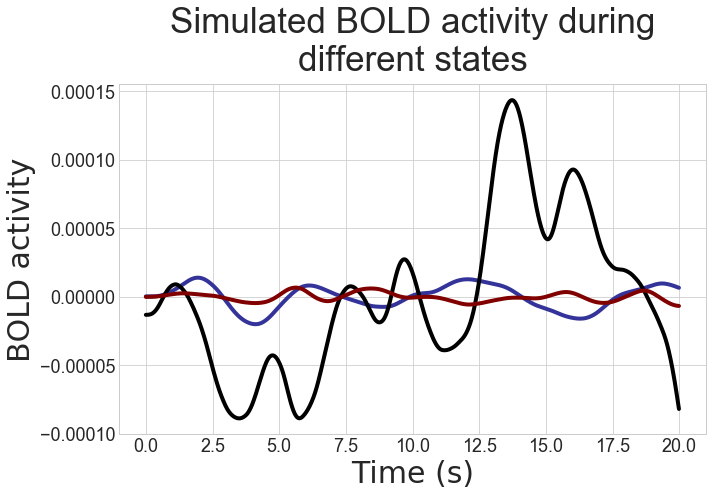

In [39]:
##### Set connectivity weights
w11 = 1
b = -.5

# Set time constant
tau = .1

# Set n timepoints
t = 2025

stimrange = [-3,0,3]
I1fp = []
I1 = []
sd_vals = []
for s in stimrange:
    d = np.random.normal(0,0.25,(t,))
    s1vec = np.ones((t,))*s

    # Calculate fixed points
    xinit1 = 0
    I1fp.append(findFP(w11,b,s,10000,xinit1,tau))

    # Set initial conditions
    xinit1 = I1fp[-1]

    #####
    ## Run simulations
    I1.append(runSim1D(w11,d,b,s1vec,t,xinit1,tau))
    # Calculate SD
    sd_vals.append(np.std(I1[-1]))


#####
sns.set_style('whitegrid')
# Generate plots
plt.figure(figsize=(10,7))
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# Plot
plt.plot(range(len(I1[0])),I1[0],label='Evoked de-activation | Var = ' + str(round(sd_vals[0],7)),color='#333399',linewidth=4)
plt.plot(range(len(I1[1])),I1[1],label='Baseline activity | Var = ' + str(round(sd_vals[1],7)),color='k',linewidth=4)
plt.plot(range(len(I1[2])),I1[2],label='Evoked activation | Var = ' + str(round(sd_vals[2],7)),color='#800000',linewidth=4)
plt.xlabel('Time (s)',fontsize=30, fontname='FreeSans')
plt.ylabel('Activity',fontsize=30, fontname='FreeSans')
plt.title('Simulated neural activity during\ndifferent states', fontsize=35,y=1.02)
plt.xticks(np.arange(0,len(I1[0])+250,250),np.arange(0,len(I1[0])+250,250)*.01)
plt.ylim([0,1])
#plt.legend(loc=1,bbox_to_anchor=(1.0,0.97), prop={'size': 24})
plt.tight_layout()
plt.savefig('Simulation_NeuralTimeseries.pdf')

# Generate BOLD plots
BOLD = []
z = np.vstack((I1[0],I1[1],I1[2]))
BOLD = bw.balloonWindkessel(z,sampling_rate=0.01)[0]
plt.figure(figsize=(10,7))
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# Plot
plt.plot(range(len(BOLD[0,:])),BOLD[0,:]-np.mean(BOLD[0,:]),
         label='Evoked de-activation',color='#333399',linewidth=4)
plt.plot(range(len(BOLD[1,:])),BOLD[1,:]-np.mean(BOLD[1,:]),
         label='Baseline activity',color='k',linewidth=4)
plt.plot(range(len(BOLD[2,:])),BOLD[2,:]-np.mean(BOLD[2,:]),
         label='Evoked activation',color='#800000',linewidth=4)
plt.xlabel('Time (s)',fontsize=30, fontname='FreeSans')
plt.ylabel('BOLD activity',fontsize=30, fontname='FreeSans')
plt.title('Simulated BOLD activity during\ndifferent states', fontsize=35,y=1.02)
plt.xticks(np.arange(0,len(I1[0])+250,250),np.arange(0,len(I1[0])+250,250)*.01)
# plt.legend(loc=1,bbox_to_anchor=(1.1,0.97), prop={'size': 24})
plt.tight_layout()
plt.savefig('Simulation_BOLDTimeseries.pdf')


## Plot physiological signals for each state

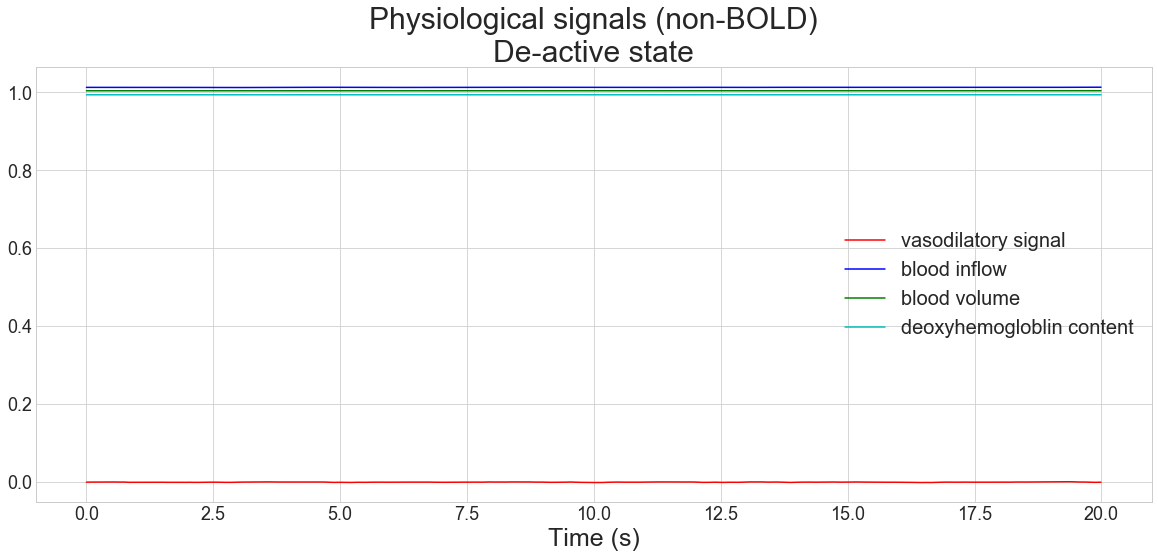

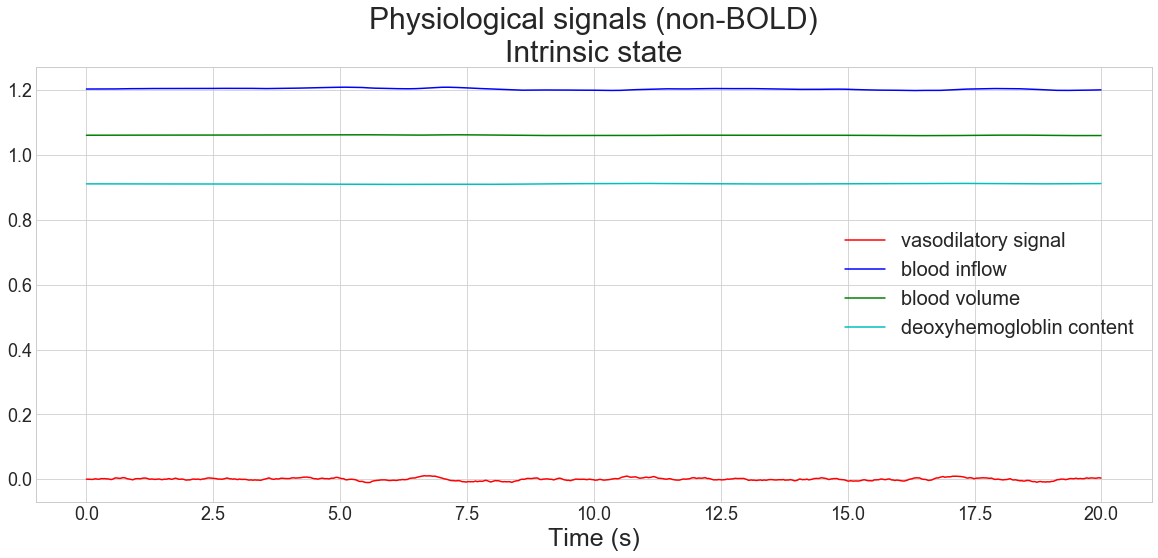

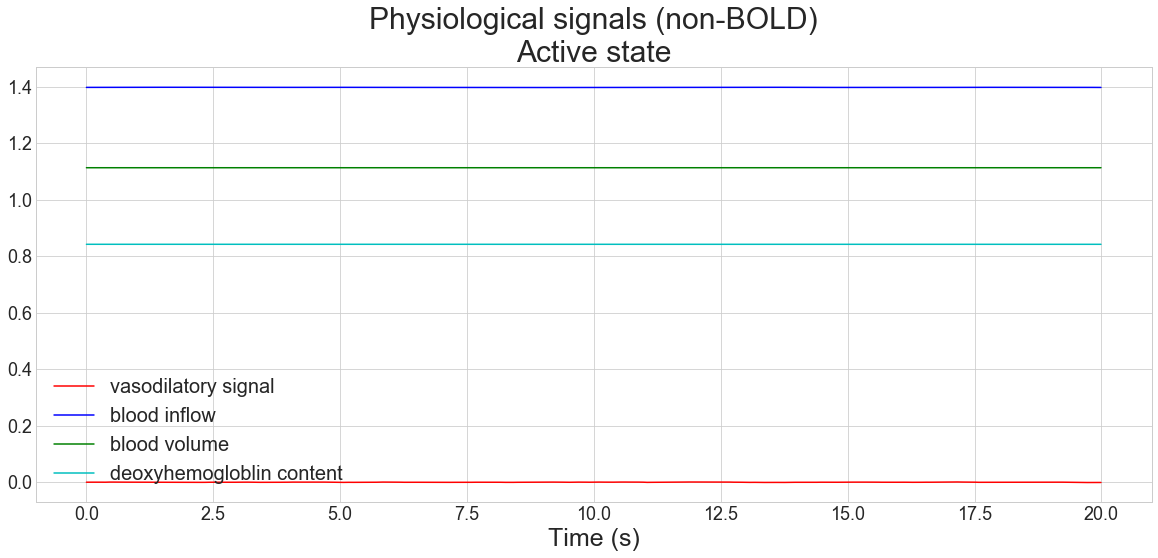

In [37]:
sampling_rate = 0.01
z = np.vstack((I1[0],I1[1],I1[2]))
BOLD, s, f, v, q  = bw.balloonWindkessel(z,sampling_rate=0.01)

plt.figure(figsize=(20,8))
plt.title('Physiological signals (non-BOLD)\nDe-active state', fontsize=30)
plt.plot(s[0,:],'r',label='vasodilatory signal')
plt.plot(f[0,:],'b',label='blood inflow')
plt.plot(v[0,:],'g',label='blood volume')
plt.plot(q[0,:],'c',label='deoxyhemogloblin content')
plt.xticks(np.arange(0,t,250),np.arange(0,t,250)*sampling_rate)
plt.xlabel('Time (s)', fontsize=25)
plt.legend(fontsize=20)

plt.figure(figsize=(20,8))
plt.title('Physiological signals (non-BOLD)\nIntrinsic state', fontsize=30)
plt.plot(s[1,:],'r',label='vasodilatory signal')
plt.plot(f[1,:],'b',label='blood inflow')
plt.plot(v[1,:],'g',label='blood volume')
plt.plot(q[1,:],'c',label='deoxyhemogloblin content')
plt.xticks(np.arange(0,t,250),np.arange(0,t,250)*sampling_rate)
plt.xlabel('Time (s)', fontsize=25)
plt.legend(fontsize=20)

plt.figure(figsize=(20,8))
plt.title('Physiological signals (non-BOLD)\nActive state', fontsize=30)
plt.plot(s[2,:],'r',label='vasodilatory signal')
plt.plot(f[2,:],'b',label='blood inflow')
plt.plot(v[2,:],'g',label='blood volume')
plt.plot(q[2,:],'c',label='deoxyhemogloblin content')
plt.xticks(np.arange(0,t,250),np.arange(0,t,250)*sampling_rate)
plt.xlabel('Time (s)', fontsize=25)
plt.legend(fontsize=20)